# <font color='blue'>Data Science Academy</font>
# <font color='blue'>Deep Learning Para Aplicações de IA com PyTorch e Lightning</font>

## <font color='blue'>Estudo de Caso 6</font>
## <font color='blue'>Sistema de Similaridade de Imagens com Deep Autoencoders</font>

![DSA](imagens/EC6.png)

## Instalando e Carregando os Pacotes

In [1]:
# Versão da Linguagem Python
from platform import python_version
print('Versão da Linguagem Python Usada Neste Jupyter Notebook:', python_version())

Versão da Linguagem Python Usada Neste Jupyter Notebook: 3.9.13


In [2]:
# Para atualizar um pacote, execute o comando abaixo no terminal ou prompt de comando:
# pip install -U nome_pacote

# Para instalar a versão exata de um pacote, execute o comando abaixo no terminal ou prompt de comando:
# !pip install nome_pacote==versão_desejada

# Depois de instalar ou atualizar o pacote, reinicie o jupyter notebook.

# Instala o pacote watermark. 
# Esse pacote é usado para gravar as versões de outros pacotes usados neste jupyter notebook.
#!pip install -q -U watermark

In [3]:
%env TF_CPP_MIN_LOG_LEVEL=3

env: TF_CPP_MIN_LOG_LEVEL=3


In [4]:
!pip install -q torch==2.0.1

In [5]:
!pip install -q torchvision==0.15.2

In [6]:
!pip install -q pytorch-lightning==2.0.3

In [7]:
# Imports
import os
import json
import math
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgb
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms
import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

In [8]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Data Science Academy" --iversions

Author: Data Science Academy

torch            : 2.0.1
pytorch_lightning: 2.0.3
seaborn          : 0.11.2
torchvision      : 0.15.2
matplotlib       : 3.5.2
json             : 2.0.9
numpy            : 1.23.5



## Carga e Processamento dos Dados

In [9]:
# Seed
pl.seed_everything(42)

Global seed set to 42


42

In [10]:
# Device
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

Device: cuda:0


In [11]:
# Pasta de dados
DATASET_PATH = "dados"

In [12]:
# Pasta dos modelos
CHECKPOINT_PATH = "modelos"

In [13]:
# Transformações aplicadas em cada imagem
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,))])

In [14]:
# Carregando o conjunto de dados de treinamento. 
imagens_treino = CIFAR10(root = DATASET_PATH, 
                         train = True, 
                         transform = transform, 
                         download = True)

Files already downloaded and verified


In [15]:
pl.seed_everything(42)

Global seed set to 42


42

In [16]:
# Divide os dados de treino em treino e validação
dataset_treino, dataset_valid = torch.utils.data.random_split(imagens_treino, [45000, 5000])

In [17]:
# Carregando o conjunto de dados de teste
dataset_teste = CIFAR10(root = DATASET_PATH, 
                        train = False, 
                        transform = transform, 
                        download = True)

Files already downloaded and verified


Agora definimos os dataloaders.

In [18]:
loader_treino = data.DataLoader(dataset_treino, 
                                batch_size = 256, 
                                shuffle = True, 
                                drop_last = True, 
                                pin_memory = True, 
                                num_workers = 4)

In [19]:
loader_valid = data.DataLoader(dataset_valid, 
                               batch_size = 256, 
                               shuffle = False, 
                               drop_last = False, 
                               num_workers = 4)

In [20]:
loader_teste = data.DataLoader(dataset_teste, 
                               batch_size = 256, 
                               shuffle = False, 
                               drop_last = False, 
                               num_workers = 4)

In [21]:
# Função para obter uma imagem
def get_train_images(num):
    return torch.stack([imagens_treino[i][0] for i in range(num)], dim = 0)

## Construindo o Modelo 

Em geral, um autoencoder consiste em um **encoder** que mapeia a entrada $x$ para um vetor de recursos de menor dimensão $z$ e um **decoder** que reconstrói a entrada $\hat{x}$ de $z$. 

Treinamos o modelo comparando $x$ com $\hat{x}$ e otimizando os parâmetros para aumentar a similaridade entre $x$ e $\hat{x}$. Veja abaixo uma pequena ilustração da estrutura do autoencoder.

<center width="100%"><img src="imagens/autoencoder_visualization.svg" style="display: block; margin-left: auto; margin-right: auto;" width="650px"/></center>

### Codificador (Encoder)

Primeiro começamos implementando o codificador. O codificador consiste efetivamente em uma rede convolucional profunda, onde reduzimos a escala da imagem camada por camada usando convoluções escalonadas. Depois de reduzir a escala da imagem três vezes, achatamos os recursos e aplicamos camadas lineares. A representação latente $z$ é, portanto, um vetor de tamanho *d*.

In [22]:
# Codificador
class Encoder(nn.Module):
    
    def __init__(self, 
                 num_input_channels : int, 
                 base_channel_size : int, 
                 latent_dim : int, 
                 act_fn : object = nn.GELU):

        super().__init__()
        
        c_hid = base_channel_size
        
        self.net = nn.Sequential(
            
            # https://www.cs.toronto.edu/~kriz/cifar.html
            # 32x32 => 16x16
            nn.Conv2d(num_input_channels, 
                      c_hid, 
                      kernel_size = 3, 
                      padding = 1, 
                      stride = 2), 
            
            act_fn(),
            
            nn.Conv2d(c_hid, 
                      c_hid, 
                      kernel_size = 3, 
                      padding = 1),
            
            act_fn(),
            
            # 16x16 => 8x8
            nn.Conv2d(c_hid, 
                      2*c_hid, 
                      kernel_size = 3, 
                      padding = 1, 
                      stride = 2), 
            
            act_fn(),
            
            nn.Conv2d(2*c_hid, 
                      2*c_hid, 
                      kernel_size = 3, 
                      padding = 1),
            
            act_fn(),
            
            # 8x8 => 4x4
            nn.Conv2d(2*c_hid, 
                      2*c_hid, 
                      kernel_size = 3, 
                      padding = 1, 
                      stride = 2), 
            
            act_fn(),
            
            nn.Flatten(),
            
            nn.Linear(2*16*c_hid, 
                      latent_dim)
        )
    
    def forward(self, x):
        return self.net(x)

Observe que não aplicamos a normalização em lote aqui. Isso ocorre porque queremos que a codificação de cada imagem seja independente de todas as outras imagens. Caso contrário, podemos introduzir correlações na codificação ou decodificação, o que não queremos ter. 

Em algumas implementações ainda é possível ver a Batch Normalization sendo utilizada, pois ela também pode servir como uma forma de regularização. No entanto, a melhor prática é usar outras técnicas de normalização, se necessário, como normalização de instância ou normalização de camada. Dado o pequeno tamanho do modelo, podemos negligenciar a normalização por enquanto.

### Decodificador (Decoder)

O decodificador é uma versão espelhada e invertida do codificador. A única diferença é que substituímos as convoluções strided por convoluções transpostas (ou seja, deconvoluções) para melhorar os recursos. 

As convoluções transpostas podem ser imaginadas como adicionando o passo à entrada em vez da saída e, portanto, podem aumentar a escala da entrada. Para uma ilustração de uma camada `nn.ConvTranspose2d` com tamanho de kernel 3, passo 2 e preenchimento 1, veja abaixo (fonte da imagem - [Vincent Dumoulin and Francesco Visin](https://arxiv.org/abs/1603.07285)):

<center width="100%"><img src="imagens/deconvolution.gif" width="250px"></center>

Você vê que para uma entrada de tamanho $3\times3$, obtemos uma saída de $5\times5$. No entanto, para realmente ter uma operação reversa da convolução, precisamos garantir que a camada dimensione a forma de entrada por um fator de 2 (por exemplo, $4\times4\to8\times8$). Para isso, podemos especificar o parâmetro `output_padding` que adiciona valores adicionais à forma de saída. Observe que não executamos preenchimento com zeros com isso, mas aumentamos a forma de saída para cálculo.

Em geral, o decodificador pode ser implementado da seguinte forma:

In [23]:
# Decodificador
class Decoder(nn.Module):
    
    def __init__(self, 
                 num_input_channels : int, 
                 base_channel_size : int, 
                 latent_dim : int, 
                 act_fn : object = nn.GELU):

        super().__init__()
        
        c_hid = base_channel_size
        
        self.linear = nn.Sequential(
            nn.Linear(latent_dim, 2*16*c_hid),
            act_fn()
        )
        
        self.net = nn.Sequential(
            
            # 4x4 => 8x8
            nn.ConvTranspose2d(2*c_hid, 
                               2*c_hid, 
                               kernel_size = 3, 
                               output_padding = 1, 
                               padding = 1, 
                               stride = 2), 
            
            act_fn(),
            
            nn.Conv2d(2*c_hid, 
                      2*c_hid, 
                      kernel_size = 3, 
                      padding = 1),
            
            act_fn(),
            
            # 8x8 => 16x16
            nn.ConvTranspose2d(2*c_hid, 
                               c_hid, 
                               kernel_size = 3, 
                               output_padding = 1, 
                               padding = 1, 
                               stride = 2), 
            
            act_fn(),
            
            nn.Conv2d(c_hid, c_hid, kernel_size = 3, padding = 1),
            
            act_fn(),
            
            # 16x16 => 32x32
            nn.ConvTranspose2d(c_hid, 
                               num_input_channels, 
                               kernel_size = 3, 
                               output_padding = 1, 
                               padding = 1, 
                               stride = 2), 
            
            # As imagens de entrada são dimensionadas entre -1 e 1, portanto, a saída também deve ser limitada
            nn.Tanh() 
        )
    
    def forward(self, x):
        x = self.linear(x)
        x = x.reshape(x.shape[0], -1, 4, 4)
        x = self.net(x)
        return x

As redes de codificador e decodificador que escolhemos aqui são relativamente simples. Normalmente, redes mais complexas são aplicadas, especialmente quando se usa uma arquitetura baseada em ResNet. Por exemplo, consulte [VQ-VAE](https://arxiv.org/abs/1711.00937) e [NVAE](https://arxiv.org/abs/2007.03898) (embora os artigos discutam arquiteturas para Variational Autoencoders, eles podem ser igualmente aplicados a Deep Autoencoders).

### Construção dos Módulos com Lightning - Deep Autoencoder

Em uma etapa final, adicionamos o codificador e o decodificador juntos na arquitetura do Deep Autoencoder. Definimos o modelo como PyTorch Lightning Module para simplificar o código de treinamento necessário:

In [24]:
# DeepAutoencoder
class DeepAutoencoder(pl.LightningModule):
    
    def __init__(self, 
                 base_channel_size: int, 
                 latent_dim: int, 
                 encoder_class : object = Encoder,
                 decoder_class : object = Decoder,
                 num_input_channels: int = 3, 
                 width: int = 32, 
                 height: int = 32):
        
        super().__init__()
        
        # Salvando os hiperparâmetros
        self.save_hyperparameters() 
        
        # Criando encoder e decoder
        self.encoder = encoder_class(num_input_channels, base_channel_size, latent_dim)
        self.decoder = decoder_class(num_input_channels, base_channel_size, latent_dim)
        
        # Exemplo de matriz de entrada necessária para visualizar o gráfico da rede
        self.example_input_array = torch.zeros(2, num_input_channels, width, height)
        
    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat
    
    def _get_reconstruction_loss(self, batch):
        x, _ = batch 
        x_hat = self.forward(x)
        loss = F.mse_loss(x, x_hat, reduction = "none")
        loss = loss.sum(dim=[1,2,3]).mean(dim = [0])
        return loss
    
    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr = 1e-3)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                         mode = 'min', 
                                                         factor = 0.2, 
                                                         patience = 20, 
                                                         min_lr = 5e-5)
        
        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "val_loss"}
    
    def training_step(self, batch, batch_idx):
        loss = self._get_reconstruction_loss(batch)                             
        self.log('train_loss', loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        loss = self._get_reconstruction_loss(batch)
        self.log('val_loss', loss)
    
    def test_step(self, batch, batch_idx):
        loss = self._get_reconstruction_loss(batch)
        self.log('test_loss', loss)

Para a função de perda, usamos o erro quadrático médio (MSE). O erro quadrático médio leva a rede a prestar atenção especial aos valores de pixel cuja estimativa está distante. Prever 127 em vez de 128 não é importante ao reconstruir, mas confundir 0 com 128 é muito pior. Observe que, ao contrário dos VAEs, não prevemos a probabilidade por valor de pixel, mas usamos uma medida de distância. Isso economiza muitos parâmetros e simplifica o treinamento. Para obter uma melhor intuição por pixel, relatamos o erro quadrado somado sobre a dimensão do lote (qualquer outra média/soma leva ao mesmo resultado/parâmetros).

No entanto, MSE também tem algumas desvantagens consideráveis. Normalmente, o MSE leva a imagens borradas onde pequenos ruídos/padrões de alta frequência são removidos, pois causam um erro muito baixo. 

Para garantir imagens realistas a serem reconstruídas, pode-se combinar Generative Adversarial Networks com Autoencoders como feito em vários trabalhos (por exemplo, veja [aqui](https://arxiv.org/abs/1704.02304), [aqui](https://arxiv.org/abs/1511.05644) ou estes [slides](http://elarosca.net/slides/iccv_autoencoder_gans.pdf)). 

Além disso, comparar duas imagens usando MSE não reflete necessariamente sua semelhança visual. Por exemplo, suponha que o modelo reconstrói uma imagem deslocada em um pixel para a direita e para baixo. Embora as imagens sejam quase idênticas, podemos obter uma perda maior do que prever um valor de pixel constante para metade da imagem (veja o código abaixo). Uma solução de exemplo para esse problema inclui o uso de uma CNN separada e pré-treinada e o uso de uma distância de recursos visuais em camadas inferiores como uma medida de distância em vez da comparação original em nível de pixel.

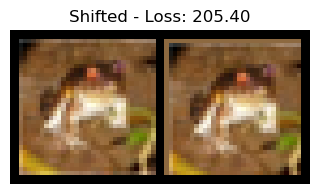

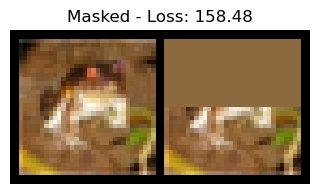

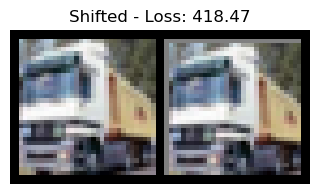

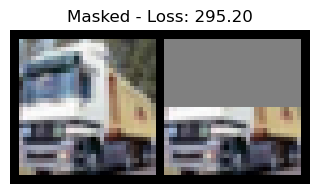

In [25]:
# Função para comparar imagens
def compare_imgs(img1, img2, title_prefix=""):

    loss = F.mse_loss(img1, img2, reduction = "sum")

    grid = torchvision.utils.make_grid(torch.stack([img1, img2], dim = 0), nrow = 2, normalize = True, range = (-1,1))
    grid = grid.permute(1, 2, 0)
    plt.figure(figsize=(4,2))
    plt.title(f"{title_prefix} Loss: {loss.item():4.2f}")
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

for i in range(2):

    img, _ = imagens_treino[i]
    img_mean = img.mean(dim=[1,2], keepdims=True)

    # Shift da imagem por 1 pixel
    SHIFT = 1
    img_shifted = torch.roll(img, shifts = SHIFT, dims = 1)
    img_shifted = torch.roll(img_shifted, shifts = SHIFT, dims = 2)
    img_shifted[:,:1,:] = img_mean
    img_shifted[:,:,:1] = img_mean
    compare_imgs(img, img_shifted, "Shifted -")

    # Definir metade da imagem para zero
    img_masked = img.clone()
    img_masked[:,:img_masked.shape[1]//2,:] = img_mean
    compare_imgs(img, img_masked, "Masked -")

## Treinando o Modelo

Durante o treinamento, queremos acompanhar o progresso do aprendizado vendo as reconstruções feitas pelo nosso modelo. Para isso, implementamos um objeto callback no PyTorch Lightning que adicionará reconstruções a cada $N$ épocas.

In [26]:
# Callback
class GenerateCallback(pl.Callback):
    
    def __init__(self, input_imgs, every_n_epochs=1):
        super().__init__()
        self.input_imgs = input_imgs 
        self.every_n_epochs = every_n_epochs 
        
    def on_train_epoch_end(self, trainer, pl_module):
        
        if trainer.current_epoch % self.every_n_epochs == 0:
            
            # Reconstrói a imagem
            input_imgs = self.input_imgs.to(pl_module.device)
            
            with torch.no_grad():
                pl_module.eval()
                reconst_imgs = pl_module(input_imgs)
                pl_module.train()
            
            # Plot e log
            imgs = torch.stack([input_imgs, reconst_imgs], dim = 1).flatten(0,1)
            grid = torchvision.utils.make_grid(imgs, nrow = 2, normalize = True, range = (-1,1))
            trainer.logger.experiment.add_image("Reconstructions", grid, global_step = trainer.global_step)

Agora escreveremos uma função de treinamento que nos permite treinar o modelo com dimensionalidade latente diferente e retornar a pontuação em validação e teste. 

In [27]:
# Função de treinamento
def treina_modelo(latent_dim):
    
    trainer = pl.Trainer(default_root_dir = os.path.join(CHECKPOINT_PATH, f"cifar10_{latent_dim}"), 
                         accelerator = "gpu" if str(device).startswith("cuda") else "cpu",
                         devices = 1,
                         max_epochs = 500, 
                         callbacks = [ModelCheckpoint(save_weights_only = True),
                                      GenerateCallback(get_train_images(8), every_n_epochs = 10),
                                      LearningRateMonitor("epoch")])
    
    trainer.logger._log_graph = True         
    trainer.logger._default_hp_metric = None 
    
    pretrained_filename = os.path.join(CHECKPOINT_PATH, f"cifar10_{latent_dim}.ckpt")
    
    # Se encontra o modelo já treinado, ele será usado. Caso contrário, será feito o treinamento.
    if os.path.isfile(pretrained_filename):
        print("Encontrei o modelo treinado. Carregando...")
        model = DeepAutoencoder.load_from_checkpoint(pretrained_filename)
    else:
        print("Iniciando o treinamento...")
        model = DeepAutoencoder(base_channel_size = 32, latent_dim = latent_dim)
        trainer.fit(model, loader_treino, loader_valid)
    

    val_result = trainer.test(model, loader_valid, verbose = False)
    test_result = trainer.test(model, loader_teste, verbose = False)
    
    result = {"teste": test_result, "valid": val_result}
    
    return model, result

## Comparando a Dimensionalidade Latente

Ao treinar um autoencoder, precisamos escolher uma dimensionalidade para a representação latente $z$. 

Quanto maior a dimensionalidade latente, melhor esperamos que seja a reconstrução. No entanto, a ideia dos autoencoders é *comprimir* os dados. Portanto, também estamos interessados em manter a dimensionalidade baixa. 

Para encontrar a melhor compensação, podemos treinar vários modelos com diferentes dimensionalidades latentes. A entrada original tem $32\times 32\times 3 = 3072$ pixels. Tendo isso em mente, uma escolha razoável para a dimensionalidade latente pode estar entre 64 e 384:

In [28]:
# Nível de precisão das operações de multiplicação
torch.set_float32_matmul_precision('high')

In [29]:
# Dicionário
model_dict = {}

In [30]:
# Loop
for latent_dim in [64, 128, 256, 384]:
    model_ld, result_ld = treina_modelo(latent_dim)
    model_dict[latent_dim] = {"model": model_ld, "result": result_ld}

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Encontrei o modelo treinado. Carregando...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Encontrei o modelo treinado. Carregando...


Testing: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Encontrei o modelo treinado. Carregando...


Testing: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Encontrei o modelo treinado. Carregando...


Testing: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

Depois de treinar os modelos, podemos plotar a perda de reconstrução sobre a dimensionalidade latente para obter uma intuição de como essas duas propriedades estão correlacionadas:

In [31]:
latent_dims = sorted([k for k in model_dict])
val_scores = [model_dict[k]["result"]["valid"][0]["test_loss"] for k in latent_dims]

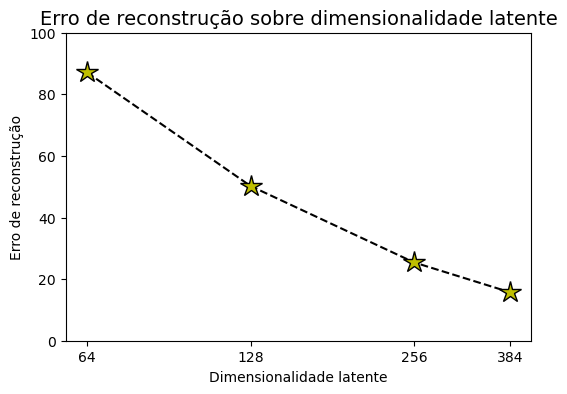

In [32]:
# Plot
fig = plt.figure(figsize = (6,4))
plt.plot(latent_dims, 
         val_scores, '--', 
         color = "#000", 
         marker = "*", 
         markeredgecolor = "#000", 
         markerfacecolor = "y", 
         markersize = 16)
plt.xscale("log")
plt.xticks(latent_dims, labels=latent_dims)
plt.title("Erro de reconstrução sobre dimensionalidade latente", fontsize=14)
plt.xlabel("Dimensionalidade latente")
plt.ylabel("Erro de reconstrução")
plt.minorticks_off()
plt.ylim(0,100)
plt.show()

Como esperávamos inicialmente, a perda de reconstrução diminui com o aumento da dimensionalidade latente. 

Para nosso modelo e configuração, as duas propriedades parecem ser exponencialmente correlacionadas. Para entender o que significam essas diferenças no erro de reconstrução, podemos visualizar reconstruções de exemplo dos quatro modelos. Para simplificar, visualizamos quatro imagens de treinamento do CIFAR10 que já vimos antes. Para modelos maiores que podem ter overfit, é recomendável usar imagens do conjunto de validação.

In [33]:
# Função de visualização
def visualize_reconstructions(model, input_imgs):

    model.eval()
    
    with torch.no_grad():
        reconst_imgs = model(input_imgs.to(model.device))
    
    reconst_imgs = reconst_imgs.cpu()
    
    # Plot
    imgs = torch.stack([input_imgs, reconst_imgs], dim = 1).flatten(0,1)
    grid = torchvision.utils.make_grid(imgs, nrow = 4, normalize = True, range = (-1,1))
    grid = grid.permute(1, 2, 0)
    plt.figure(figsize=(7,4.5))
    plt.title(f"Reconstruído a partir de {model.hparams.latent_dim} latentes")
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

In [34]:
input_imgs = get_train_images(4)

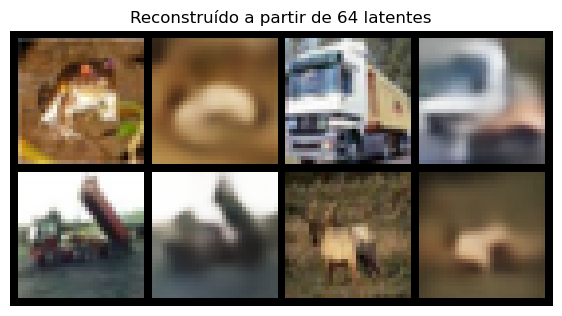

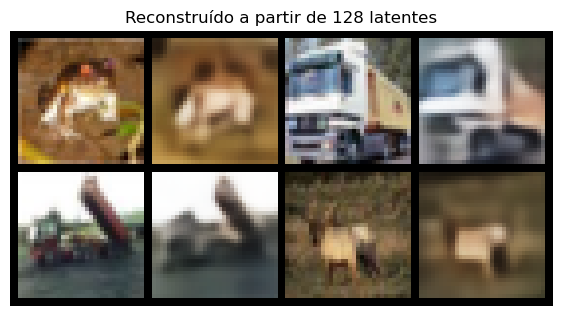

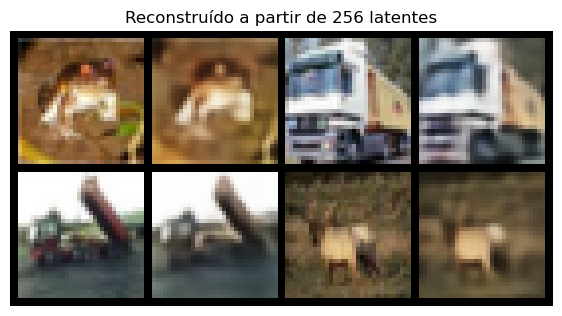

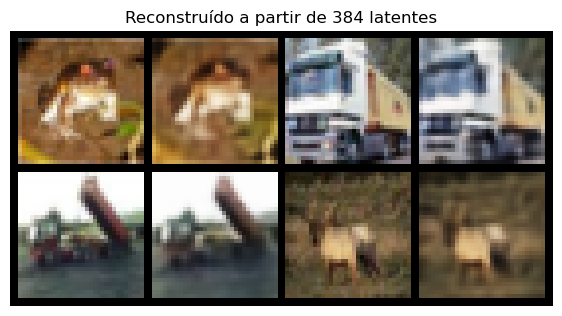

In [35]:
# Loop
for latent_dim in model_dict:
    visualize_reconstructions(model_dict[latent_dim]["model"], input_imgs)

Claramente, a menor dimensionalidade latente só pode salvar informações sobre a forma e a cor do objeto, mas a imagem reconstruída é extremamente embaçada e é difícil reconhecer o objeto original na reconstrução. 

Com 128 recursos, podemos reconhecer algumas formas novamente, embora a imagem permaneça embaçada. Os modelos com as bidimensionalidades mais altas reconstroem as imagens muito bem. A diferença entre 256 e 384 é marginal à primeira vista, mas pode ser notada ao comparar, por exemplo, os fundos da primeira imagem (as características 384 modelam mais o padrão do que 256).

## Explorando Limitações do Modelo

Antes de continuar com as aplicações do Autoencoder, podemos explorar algumas limitações do nosso modelo. 

Por exemplo, o que acontece se tentarmos reconstruir uma imagem que está claramente fora da distribuição do nosso conjunto de dados? Esperamos que o decodificador tenha aprendido alguns padrões comuns no conjunto de dados e, portanto, pode falhar em reconstruir imagens que não seguem esses padrões.

A primeira experiência que podemos tentar é reconstruir o ruído. Criamos, portanto, duas imagens cujos pixels são amostrados aleatoriamente a partir de uma distribuição uniforme sobre os valores dos pixels e visualizamos a reconstrução do modelo (fique à vontade para testar diferentes dimensionalidades latentes):

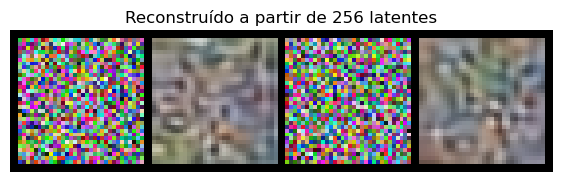

In [36]:
rand_imgs = torch.rand(2, 3, 32, 32) * 2 - 1
visualize_reconstructions(model_dict[256]["model"], rand_imgs)

A reconstrução do ruído é bastante pobre e parece apresentar alguns padrões grosseiros. Como a entrada não segue os padrões do conjunto de dados CIFAR, o modelo tem problemas para reconstruí-la com precisão.

Também podemos verificar o quão bem o modelo pode reconstruir outros padrões codificados manualmente:

In [37]:
plain_imgs = torch.zeros(4, 3, 32, 32)

# Canal de cor única
plain_imgs[1,0] = 1 

# Checkboard
plain_imgs[2,:,:16,:16] = 1
plain_imgs[2,:,16:,16:] = -1

# Progressão de cores
xx, yy = torch.meshgrid(torch.linspace(-1,1,32), torch.linspace(-1,1,32))
plain_imgs[3,0,:,:] = xx
plain_imgs[3,1,:,:] = yy

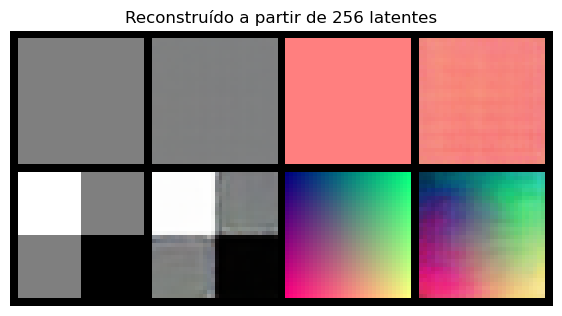

In [38]:
visualize_reconstructions(model_dict[256]["model"], plain_imgs)

As imagens simples e constantes são reconstruídas relativamente bem, embora o canal de cor única contenha algum ruído perceptível. As bordas duras do padrão do Checkboard não são tão nítidas quanto o pretendido, assim como a progressão de cores, porque esses padrões nunca ocorrem nas imagens do mundo real do CIFAR.

Em geral, os autoencoders tendem a falhar na reconstrução de ruídos de alta frequência (ou seja, grandes mudanças repentinas em poucos pixels) devido à escolha do MSE como função de perda. 

Pequenos desalinhamentos no decodificador podem levar a grandes perdas para que o modelo se ajuste ao valor/média esperado nessas regiões. Para ruídos de baixa frequência, um desalinhamento de alguns pixels não resulta em uma grande diferença na imagem original. No entanto, quanto maior a dimensionalidade latente se torna, mais desse ruído de alta frequência pode ser reconstruído com precisão.

## Gerando Novas Imagens

o que aconteceria se realmente inseríssemos um vetor latente amostrado aleatoriamente no decodificador? Vamos descobrir abaixo:

In [39]:
model = model_dict[256]["model"]

In [40]:
latent_vectors = torch.randn(8, model.hparams.latent_dim, device=model.device)

In [41]:
with torch.no_grad():
    imgs = model.decoder(latent_vectors)
    imgs = imgs.cpu()

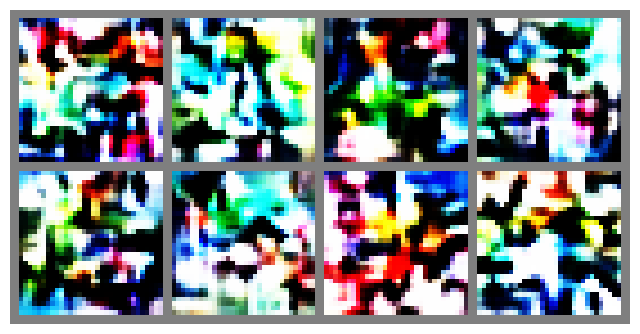

In [42]:
# Grid
grid = torchvision.utils.make_grid(imgs, nrow = 4, normalize = True, range = (-1,1), pad_value = 0.5)
grid = grid.permute(1, 2, 0)
plt.figure(figsize = (8,5))
plt.imshow(grid)
plt.axis('off')
plt.show()

Como podemos ver, as imagens geradas parecem mais arte do que imagens realistas. Como o autoencoder foi autorizado a estruturar o espaço latente da maneira que melhor se adaptasse à reconstrução, não há incentivo para mapear todos os vetores latentes possíveis para imagens realistas. Além disso, a distribuição no espaço latente é desconhecida para nós e não segue necessariamente uma distribuição normal multivariada. 

## Encontrando Imagens Visualmente Semelhantes

Uma aplicação dos autoencoders é construir um mecanismo de pesquisa baseado em imagens para recuperar imagens visualmente semelhantes. Isso pode ser feito representando todas as imagens como sua dimensionalidade latente e encontrando as imagens $K$ mais próximas neste domínio. 

O primeiro passo para tal mecanismo de busca é codificar todas as imagens em $z$. A seguir, usaremos o conjunto de treinamento como corpus de busca e o conjunto de teste como consultas ao sistema.

In [43]:
# Se você quiser tentar uma dimensionalidade latente diferente, mude aqui!
model = model_dict[128]["model"] 

In [44]:
def embed_imgs(model, data_loader):
    
    # Encode de todas as imagens no data_laoder usando o modelo e retorna imagens e codificações
    img_list, embed_list = [], []
    model.eval()
    for imgs, _ in tqdm(data_loader, desc = "Encoding images", leave = False):
        
        with torch.no_grad():
            z = model.encoder(imgs.to(model.device))
        
        img_list.append(imgs)
        
        embed_list.append(z)
    
    return (torch.cat(img_list, dim = 0), torch.cat(embed_list, dim = 0))

In [45]:
train_img_embeds = embed_imgs(model, loader_treino)
test_img_embeds = embed_imgs(model, loader_teste)

Encoding images:   0%|          | 0/175 [00:00<?, ?it/s]

Encoding images:   0%|          | 0/40 [00:00<?, ?it/s]

Depois de codificar todas as imagens, só precisamos escrever uma função que encontre as imagens $K$ mais próximas e retorne. Usamos a distância euclidiana aqui, mas outras distâncias semelhantes ao cosseno também podem ser usadas.

In [46]:
# Função do sistema de similaridade
def find_similar_images(query_img, query_z, key_embeds, K = 8):
    dist = torch.cdist(query_z[None,:], key_embeds[1], p = 2)
    dist = dist.squeeze(dim=0)
    dist, indices = torch.sort(dist)
    imgs_to_display = torch.cat([query_img[None], key_embeds[0][indices[:K]]], dim = 0)
    grid = torchvision.utils.make_grid(imgs_to_display, nrow = K+1, normalize = True, range = (-1,1))
    grid = grid.permute(1, 2, 0)
    plt.figure(figsize = (12,3))
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

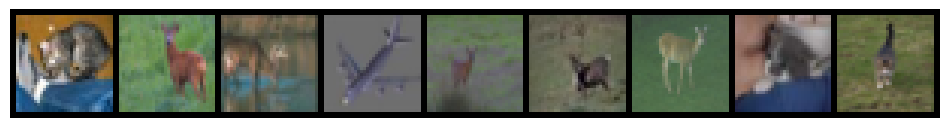

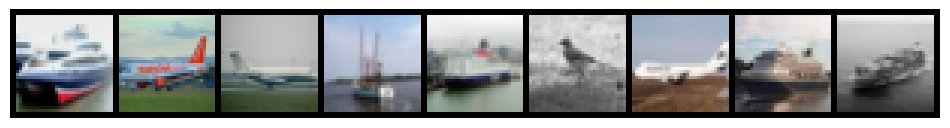

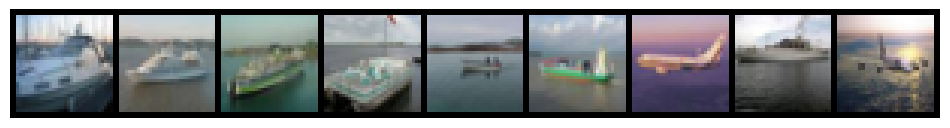

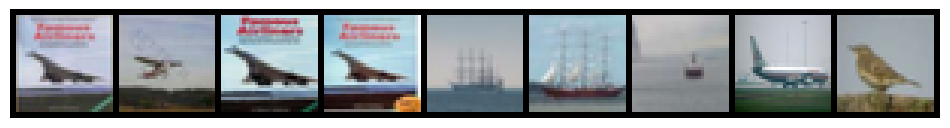

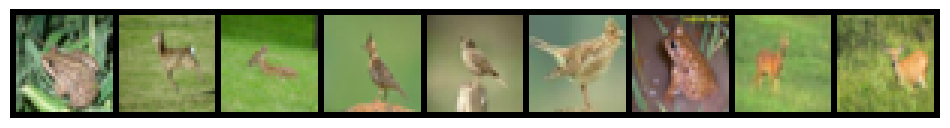

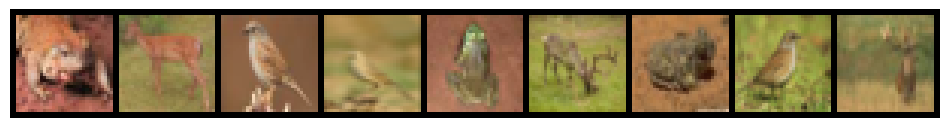

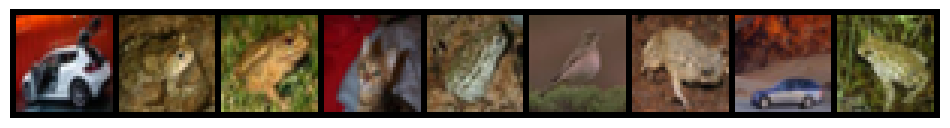

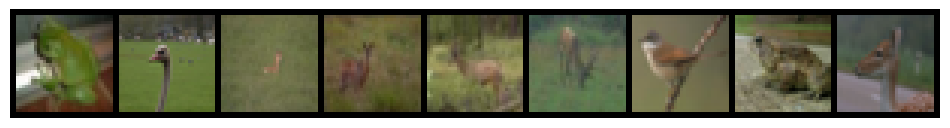

In [47]:
# Plot das imagens mais próximas para as primeiras N imagens de teste como exemplo
for i in range(8):
    find_similar_images(test_img_embeds[0][i], test_img_embeds[1][i], key_embeds = train_img_embeds)

Com base em nosso autoencoder, vemos que podemos recuperar muitas imagens semelhantes para a entrada de teste. 

Em particular, na linha 4, podemos identificar que algumas imagens de teste podem não ser tão diferentes do conjunto de treinamento quanto pensávamos (mesmo pôster, apenas escala/escala de cores diferentes). 

Também vemos que, embora não tenhamos dado nenhum rótulo ao modelo, ele pode agrupar diferentes classes em diferentes partes do espaço latente (avião + navio, animais, etc.). É por isso que os autoencoders também podem ser usados como uma estratégia de pré-treinamento para redes profundas, especialmente quando temos um grande conjunto de imagens não rotuladas (geralmente o caso). 

No entanto, deve-se observar que o plano de fundo ainda desempenha um papel importante nos autoencoders, mas não na classificação. Portanto, não obtemos clusters "perfeitos" e precisamos ajustar esses modelos para classificação.

# Fim